# Cross-validation 
> Implement cross-validation to evaluate models on historical data

Time series cross-validation is a method for evaluating how a model would have performed on historical data. It works by defining a sliding window across past observations and predicting the period following it. It differs from standard cross-validation by maintaining the chronological order of the data instead of randomly splitting it.

This method allows for a better estimation of our model's predictive capabilities by considering multiple periods. When only one window is used, it resembles a standard train-test split, where the test data is the last set of observations, and the training set consists of the earlier data.

The following graph showcases how time series cross-validation works. 

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

In this tutorial we'll explain how to perform cross-validation in `NeuralForecast`. 

**Outline:**
1. Install NeuralForecast

2. Load and plot the data 

3. Train multiple models using cross-validation

4. Evaluate models and select the best for each series

5. Plot cross-validation results

:::{.callout-warning collapse="true"}
## Prerequesites
This guide assumes basic familiarity with `neuralforecast`. For a minimal example visit the [Quick Start](../getting-started/02_quickstart.ipynb)
:::

## 1. Install NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

## 2. Load and plot the data 

We'll use pandas to load the hourly dataset from the [M4 Forecasting Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), which has been stored in a parquet file for efficiency. 

In [ ]:
import os
import logging

import pandas as pd
from IPython.display import display

In [ ]:
os.environ['PL_TRAINER_ENABLE_PROGRESS_BAR'] = '0'
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [ ]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


The input to `neuralforecast` should be a data frame in long format with three columns: `unique_id`, `ds`, and `y`.

- `unique_id` (string, int, or category): A unique identifier for each time series. 

- `ds` (int or timestamp): An integer indexing time or a timestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS.

- `y` (numeric): The target variable to forecast.

This dataset contains 414 unique time series. To reduce the total execution time, we'll use only the first 10. 

In [ ]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example run faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)

To plot the series, we'll use the `plot_series` method from `utilsforecast.plotting`. `utilsforecast` is a dependency of `neuralforecast` so it should be already installed. 

In [ ]:
from utilsforecast.plotting import plot_series

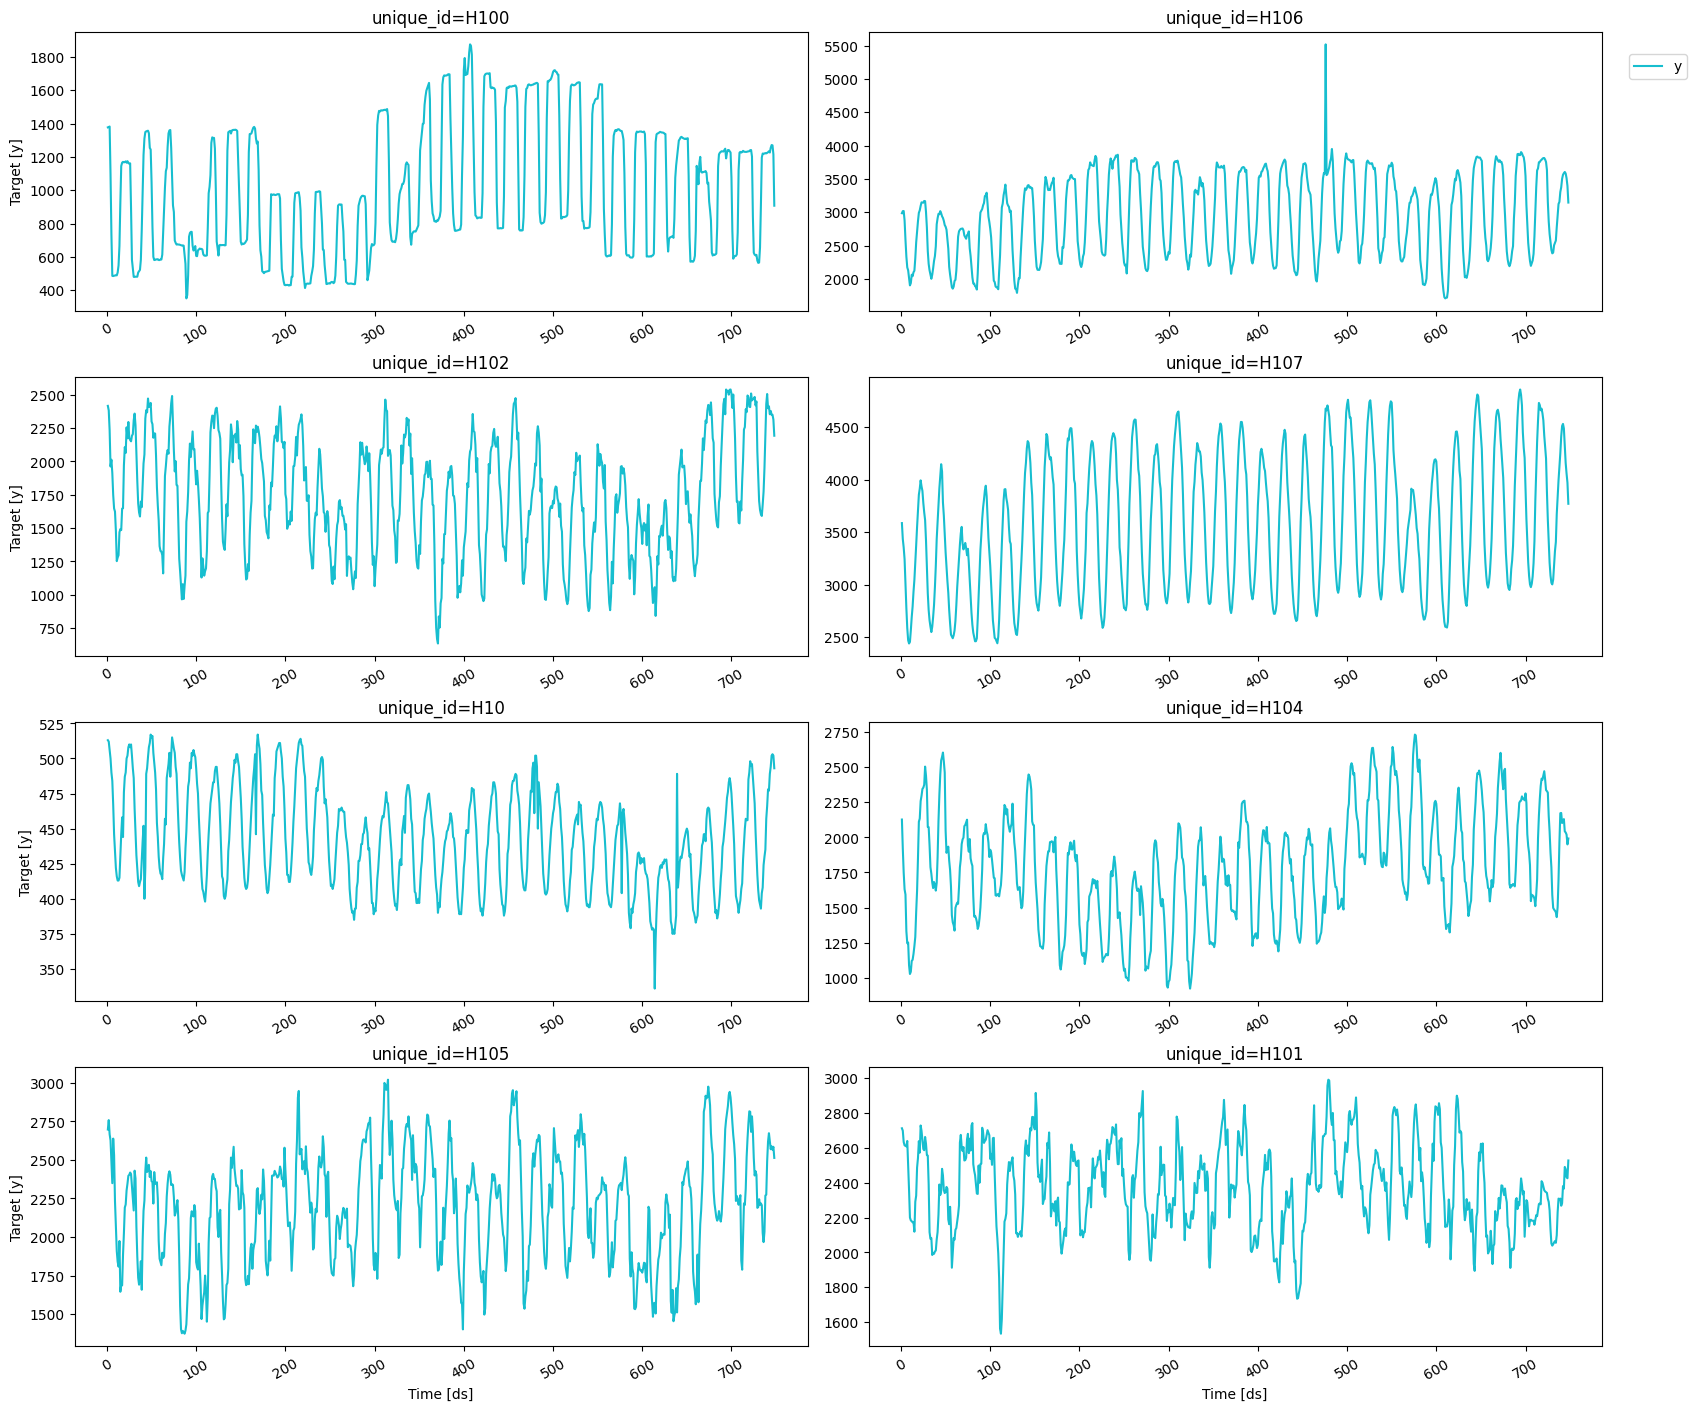

In [ ]:
plot_series(Y_df)

## 3. Train multiple models using cross-validation

We'll train different models from `neuralforecast` using the `cross-validation` method to decide which one perfoms best on the historical data. To do this, we need to import the `NeuralForecast` class and the models that we want to compare. 

In [ ]:
from neuralforecast import NeuralForecast 
from neuralforecast.auto import MLP, NBEATS, NHITS
from neuralforecast.losses.pytorch import MQLoss

In this tutorial, we will use `neuralforecast's` [MPL](https://nixtlaverse.nixtla.io/neuralforecast/models.mlp.html), [NBEATS](https://nixtlaverse.nixtla.io/neuralforecast/models.nbeats.html), and [NHITS](https://nixtlaverse.nixtla.io/neuralforecast/models.nhits.html) models. 

First, we need to create a list of models and then instantiate the `NeuralForecast` class. For each model, we'll define the following hyperparameters:

- `h`: The forecast horizon. Here, we will use the same horizon as in the M4 competition, which was 48 steps ahead.

- `input_size`: The number of historical observations (lags) that the model uses to make predictions. In this case, it will be twice the forecast horizon.

- `loss`: The loss function to optimize. Here, we'll use the Multi Quantile Loss (MQLoss) from `neuralforecast.losses.pytorch`.

:::{.callout-warning collapse="true"}
The Multi Quantile Loss (MQLoss) is the sum of the quantile losses for each target quantile. The quantile loss for a single quantile measures how well a model has predicted a specific quantile of the actual distribution, penalizing overestimations and underestimations asymmetrically based on the quantile's value. For more details see [here](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#multi-quantile-loss-mqloss). 
:::

While there are other hyperparameters that can be defined for each model, we'll use the default values for the purposes of this tutorial. To learn more about the hyperparameters of each model, please check out the corresponding documentation.

In [ ]:
horizon = 48 
models = [MLP(h=horizon, input_size=2*horizon, loss=MQLoss()), 
          NBEATS(h=horizon, input_size=2*horizon, loss=MQLoss()), 
          NHITS(h=horizon, input_size=2*horizon, loss=MQLoss()),]
nf = NeuralForecast(models=models, freq=1)

Seed set to 1
Seed set to 1
Seed set to 1


The `cross_validation` method takes the following arguments: 

- `df`: The data frame in the format described in section 2. 

- `n_windows` (int): The number of windows to evaluate. Default is 1 and here we'll use 3. 

- `step_size` (int): The number of steps between consecutive windows to produce the forecasts. In this example, we'll set `step_size=horizon` to produce non-overlapping forecasts. The following diagram shows how the forecasts are produced based on the `step_size` parameter and forecast horizon `h` of a model. In this diagram `step_size=2` and `h=4`.

![](../../imgs_indx/predict_insample.png)

- `refit` (bool or int): Whether to retrain models for each cross-validation window. If `False`, the models are trained at the beginning and then used to predict each window. If a positive integer, the models are retrained every `refit` windows. Default is `False`, but here we'll use `refit=1` so that the models are retrained after each window using the data with timestamps up to and including the cutoff. 

In [ ]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=horizon, refit=1)

It's worth mentioning that the default version of the `cross_validation` method in `neuralforecast` diverges from other libraries, where models are typically retrained at the start of each window. By default, it trains the models once and then uses them to generate predictions over all the windows, thus reducing the total execution time. For scenarios where the models need to be retrained, you can use the `refit` parameter to specify the number of windows after which the models should be retrained. 

In [ ]:
cv_df.head()

,unique_id,ds,cutoff,MLP-median,MLP-lo-90,MLP-lo-80,MLP-hi-80,MLP-hi-90,NBEATS-median,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,y
0,H1,605,604,630.349060,566.307068,577.870239,708.477600,712.254150,626.478210,582.834473,597.013794,624.287659,653.175964,622.241150,567.838135,586.760376,668.188782,659.781067,622.0
1,H1,606,604,585.820374,493.236633,503.230530,645.661133,675.120361,556.979431,526.553650,520.657654,596.815918,589.283020,566.518494,517.265991,515.924683,604.766785,639.438599,558.0
2,H1,607,604,530.625977,441.605194,459.140106,594.764465,633.654541,523.716309,472.204712,495.788727,540.741089,552.067322,512.103821,451.125793,477.172058,548.852417,564.310486,513.0
3,H1,608,604,496.266418,412.336151,422.470306,557.838257,585.249390,486.418243,467.397186,473.552673,525.132446,511.859619,486.631104,420.642029,439.170166,517.347168,539.059570,476.0
4,H1,609,604,468.644623,395.862976,409.881836,522.402161,587.682190,473.056915,446.661713,457.302490,491.170868,499.522491,456.727844,407.459442,410.142670,507.007324,520.796692,449.0


The output of the `cross-validation` method is a data frame that includes the following columns:

- `unique_id`: The unique identifier for each time series. 

- `ds`: The timestamp or temporal index. 

- `cutoff`: The last timestamp or temporal index used in that cross-validation window. 

- `"model"`: Columns with the model’s point forecasts (median) and prediction intervals. By default, the 80 and 90% prediction intervals are included when using the MQLoss.

- `y`: The actual value.

## 4. Evaluate models and select the best for each series

To evaluate the point forecasts of the models, we'll use the Root Mean Squared Error (RMSE), defined as the square root of the mean of the squared differences between the actual and the predicted values. 

For convenience, we'll use the `evaluate` and the `rmse` functions from `utilsforecast`.

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse 

The `evaluate` function takes the following arguments: 

- `df`: The data frame with the forecasts to evaluate. 

- `metrics` (list): The metrics to compute. 

- `models` (list): Names of the models to evaluate. Default is `None`, which uses all columns after removing `id_col`, `time_col`, and `target_col`. 

- `id_col` (str): Column that identifies unique ids of the series. Default is `unique_id`.

- `time_col` (str): Column with the timestamps or the temporal index. Default is `ds`.

- `target_col` (str): Column with the target variable. Default is `y`.

Notice that if we use the default value of `models`, then we need to exclude the `cutoff` column from the cross-validation data frame. 

In [ ]:
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[rmse])

For each unique id, we'll select the model with the lowest RMSE. 

In [ ]:
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df

,unique_id,metric,MLP-median,NBEATS-median,NHITS-median,best_model
0,H1,rmse,41.636492,39.277314,43.176677,NBEATS-median
1,H10,rmse,26.544711,15.540037,19.253340,NBEATS-median
2,H100,rmse,171.647549,166.811197,233.774879,NBEATS-median
3,H101,rmse,372.395826,272.311480,171.856982,NHITS-median
4,H102,rmse,470.877063,296.628817,344.146044,NBEATS-median
5,H103,rmse,10209.629348,8931.229973,8808.555886,NHITS-median
6,H104,rmse,203.656224,208.518199,144.004484,NHITS-median
7,H105,rmse,299.359214,331.195206,274.353142,NHITS-median
8,H106,rmse,212.488910,356.315381,354.211495,MLP-median
9,H107,rmse,213.150960,195.409269,200.016780,NBEATS-median


We can summarize the results to see how many times each model won. 

In [ ]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'num. of unique_ids']
summary_df

,metric,model,num. of unique_ids
0,rmse,MLP-median,1
1,rmse,NHITS-median,4
2,rmse,NBEATS-median,5


With this information, we now know which model performs best for each series in the historical data. 

## 5. Plot cross-validation results

To visualize the cross-validation results, we will use the `plot_series` method again. We'll need to rename the `y` column in the cross-validation output to avoid duplicates with the original data frame. We'll also exclude the `cutoff` column and use the `max_insample_length argument` to plot only the last 300 observations for better visualization. 

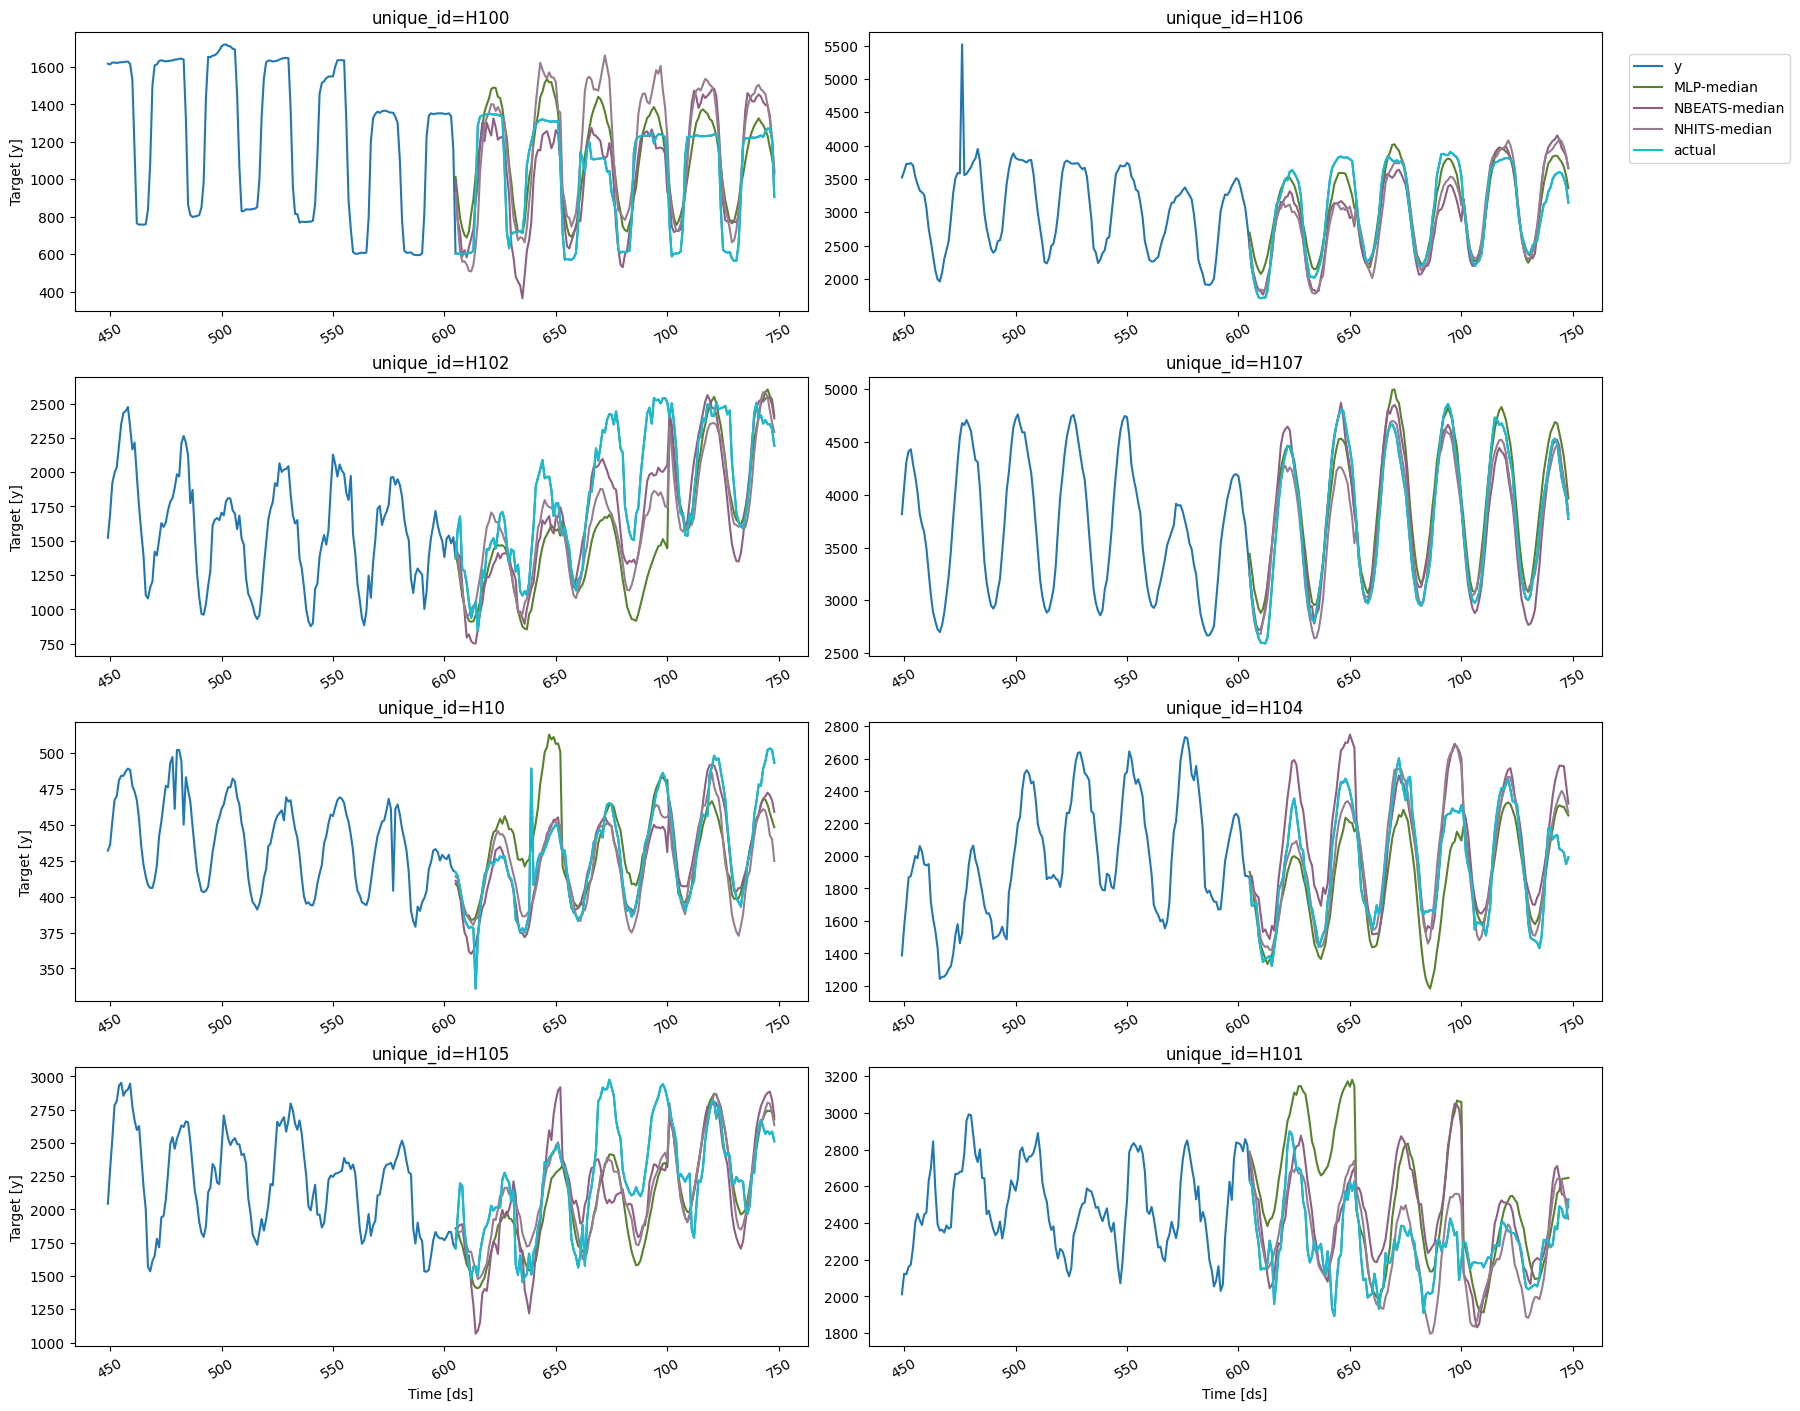

In [ ]:
cv_df.rename(columns = {'y': 'actual'}, inplace=True) # rename actual values 
plot_series(Y_df, cv_df.drop(columns='cutoff'), max_insample_length=300)

To clarify the concept of cross-validation further, we'll plot the forecasts generated at each cutoff for the series with `unique_id='H1'`. There are three cutoffs because we set `n_windows=3`. In this example, we used `refit=1`, so each model is retrained for each window using data with timestamps up to and including the respective cutoff. Additionally, since `step_size` is equal to the forecast horizon, the resulting forecasts are non-overlapping

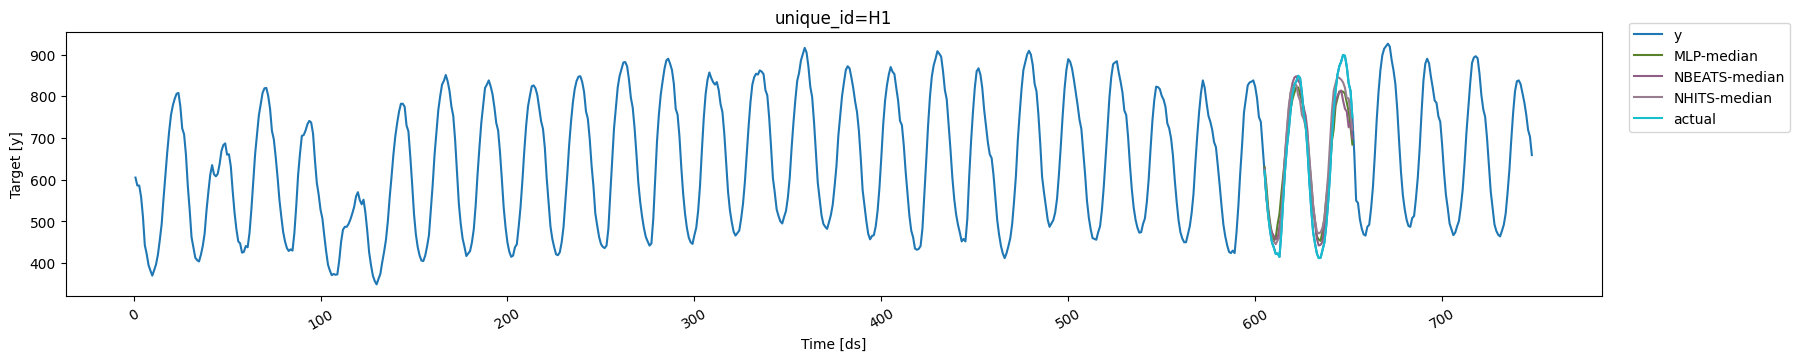

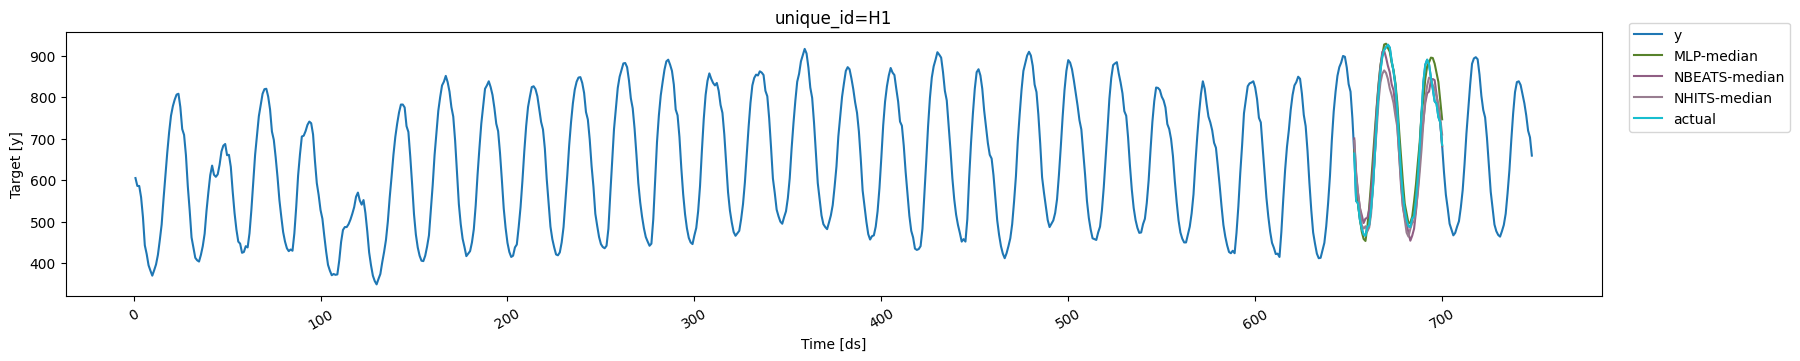

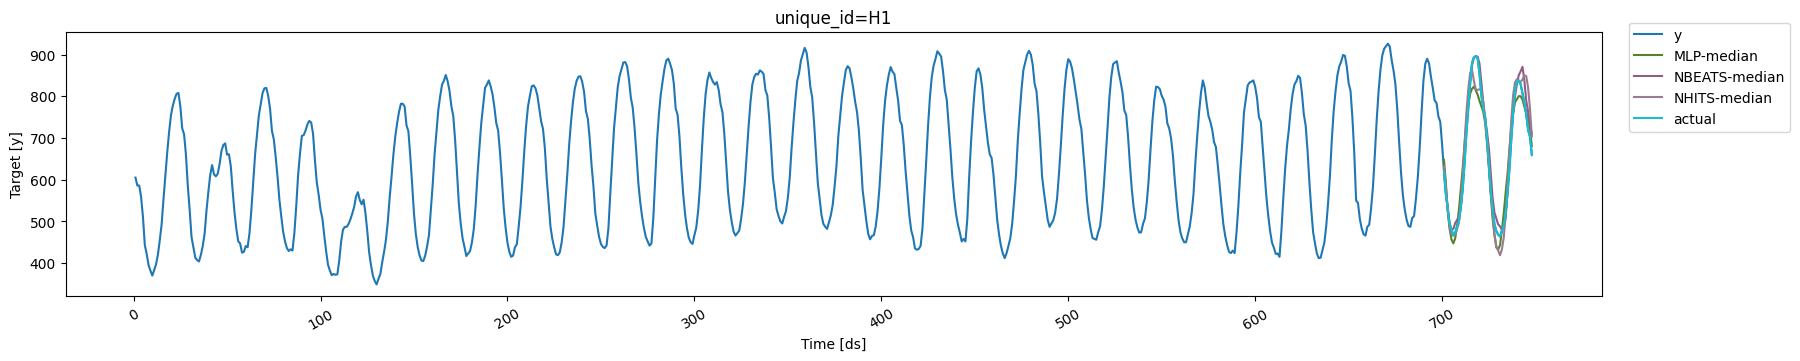

In [ ]:
cutoff1, cutoff2, cutoff3 = cv_df['cutoff'].unique()
for cutoff in cv_df['cutoff'].unique():
    display(
        plot_series(
            Y_df,
            cv_df[cv_df['cutoff'] == cutoff].drop(columns='cutoff'),
            ids=['H1'], # use ids parameter to select specific series
        )
    )